In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [ ]:
def wb_initialization(X, y, neural_layers, initializer='random'):
  n_x = X.shape[0]
  n_y = y.shape[0]

  weights = {}
  bias = {}
  layers = neural_layers.copy()
  layers.extend([n_y])

  num_layers = len(layers)
  for lyr in range(num_layers):
    if lyr == 0:
      weights['w1'] = np.ones((layers[0], n_x))
      bias['b1'] = np.zeros((layers[0], 1))
    else:
      weights['w' + str(lyr+1)] = np.ones((layers[lyr], layers[lyr-1]))
      bias['b' + str(lyr+1)] = np.zeros((layers[lyr], 1))

  if initializer == 'zeros':
    for lyr, weigh in weights.items():
      weights[lyr] = weigh = np.multiply(np.zeros(weigh.shape), weigh)

  elif initializer == 'random':
    for lyr, weigh in weights.items():
      r, c = weigh.shape
      weights[lyr] = weigh = np.multiply(np.random.rand(r, c), weigh)

  elif initializer == 'He_normal':
    for lyr, weigh in weights.items():
      r, c = weigh.shape
      w_layer = int(lyr[(lyr.index('w') + 1):])
      if w_layer == 1:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(2/n_x), weigh)
      else:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(2/layers[w_layer - 1]), weigh)

  elif initializer == 'He_uniform':
    for lyr, weigh in weights.items():
      r, c = weigh.shape
      w_layer = int(lyr[(lyr.index('w') + 1):])
      if w_layer == 1:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(6/n_x), weigh)
      else:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(6/layers[w_layer - 1]), weigh)

  elif initializer == 'Glorot_normal':
    for lyr, weigh in weights.items():
      r, c = weigh.shape
      w_layer = int(lyr[(lyr.index('w') + 1):])
      if w_layer == 1:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(2/(n_x + layers[w_layer-1])), weigh)
      else:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(2/(layers[w_layer - 2] + layers[w_layer - 1])), weigh)

  elif initializer == 'Glorot_uniform':
    for lyr, weigh in weights.items():
      r, c = weigh.shape
      w_layer = int(lyr[(lyr.index('w') + 1):])
      if w_layer == 1:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(6/(n_x + w_layer)), weigh)
      else:
        weights[lyr] = weigh = np.multiply(np.random.rand(r, c)*np.sqrt(6/(layers[w_layer - 2] + layers[w_layer - 1])), weigh)

  return weights, bias

In [ ]:
def shuffle(X):
  m = X.shape[1]
  shuffled_index = np.random.permutation(range(m))
  return shuffled_index

def batch_division(X, y, batch_size):
  m = X.shape[1]
  shuffled_index = shuffle(X)

  X_shuffled = X[:, shuffled_index]
  y_shuffled = y[:, shuffled_index]

  if batch_size == m:
    batch = []
    full_batch = (X_shuffled[:, :], y_shuffled[:, :])
    batch.append(full_batch)
    return batch
  elif batch_size == 1:
    batches = []
    for batch in range(m):
      batch = (X_shuffled[:, batch], y_shuffled[:, batch])
      batches.append(batch)
    return batches
  else:
    full_mini_batches = int(np.floor(m/batch_size))
    non_full_batch_size = m % batch_size

    mini_batches = []
    for mini_batch in range(full_mini_batches):
      mini_batch_X = X_shuffled[:, batch_size*(mini_batch):batch_size*(mini_batch + 1)]
      mini_batch_y = y_shuffled[:, batch_size*(mini_batch):batch_size*(mini_batch + 1)]
      batch = (mini_batch_X, mini_batch_y)
      mini_batches.append(batch)

    if non_full_batch_size != 0:
      mini_batch_X = X_shuffled[:, batch_size*(full_mini_batches):]
      mini_batch_y = y_shuffled[:, batch_size*(full_mini_batches):]
      batch = (mini_batch_X, mini_batch_y)
      mini_batches.append(batch)

    return mini_batches

In [ ]:
def relu(z):
  return np.maximum(0, z)

def sigmoid(z):
  return 1/(1 + np.exp(-z))

def softmax(z):
  return (np.exp(z))/np.sum(np.exp(z), axis=1, keepdims=True)

In [ ]:
def forward_propagation(X, y, neural_layers, weights, bias, non_linear_function='sigmoid'):
  activations = {'a0': X}
  n_y = y.shape[0]
  layers = neural_layers.copy()
  layers.extend([n_y])
  L = len(layers)

  for layer in range(L):
    if layer == L-1:
      z = np.dot(weights['w' + str(layer+1)], activations['a' + str(layer)]) + bias['b' + str(layer+1)]
      if non_linear_function == 'sigmoid':
        activations['a' + str(layer+1)] = sigmoid(z)
      elif non_linear_function == 'softmax':
        activations['a' + str(layer+1)] = softmax(z)
    else:
      z = np.dot(weights['w' + str(layer+1)], activations['a' + str(layer)]) + bias['b' + str(layer+1)]
      activations['a' + str(layer+1)] = relu(z)

  return activations

def forward_prop_with_dropout(X, y, neural_layers, weights, bias, drop_nodes, non_linear_function='sigmoid'):
  activations = {'a0': X}
  n_y = y.shape[0]
  layers = neural_layers.copy()
  layers.extend([n_y])
  L = len(layers)
  d = {}

  for layer in range(L):
    if layer == L-1:
      z = np.dot(weights['w' + str(layer+1)], activations['a' + str(layer)]) + bias['b' + str(layer+1)]
      if non_linear_function == 'sigmoid':
        activations['a' + str(layer+1)] = sigmoid(z)
      elif non_linear_function == 'softmax':
        activations['a' + str(layer+1)] = softmax(z)
    else:
      z = np.dot(weights['w' + str(layer+1)], activations['a' + str(layer)]) + bias['b' + str(layer+1)]
      activations['a' + str(layer+1)] = relu(z)
      d['l' + str(layer+1)] = np.random.rand(activations['a' + str(layer+1)].shape[0], activations['a' + str(layer+1)].shape[1])
      d['l' + str(layer+1)] = (d['l' + str(layer+1)] <= drop_nodes).astype(int)
      activations['a' + str(layer+1)] = np.multiply(activations['a' + str(layer+1)], d['l' + str(layer+1)])/drop_nodes

  return activations, d

In [ ]:
def compute_cost(y, y_hat):
  m = y_hat.shape[1]
  return (-1/m)*np.sum(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat))

def compute_regularized_cost(y, y_hat, lmbda, weights, regularization):
  m = y_hat.shape[1]
  cross_entropy_cost =  (-1/m)*np.sum(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat))
  if regularization == 'L2':
    weights_sum = sum([np.sum(np.square(weight)) for weight in weights.values()])
  elif regularization == 'L1':
    weights_sum = sum([np.sum(weight) for weight in weights.values()])
  else:
    weights_sum = 0
  regularized_cost = (lmbda/(2*m))*weights_sum
  total_cost = cross_entropy_cost + regularized_cost
  return total_cost

In [ ]:
def back_propagation(X, y, layers, activations, weights, optimization_algo, batch_size):
  L = len(layers) + 1
  if optimization_algo == 'sgd' or batch_size == 1:
    m = 1
  else:
    m = X.shape[1]

  grads = {}

  grads['dZ' + str(L)] = activations['a' + str(L)] - y
  for lyr in range(L, 0, -1):
    if lyr == 1:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T)
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
    else:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T)
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
      grads['dA' + str(lyr - 1)] = np.dot(weights['w' + str(lyr)].T, grads['dZ' + str(lyr)])
      grads['dZ' + str(lyr - 1)] = np.multiply(grads['dA' + str(lyr - 1)], np.int64(activations['a' + str(lyr - 1)] > 0))

  return grads

def back_propagation_with_dropout(X, y, d, layers, activations, weights, bias, optimization_algo, batch_size, drop_nodes):
  L = len(layers) + 1
  if optimization_algo == 'sgd' or batch_size == 1:
    m = 1
  else:
    m = X.shape[1]

  grads = {}

  grads['dZ' + str(L)] = activations['a' + str(L)] - y
  for lyr in range(L, 0, -1):
    if lyr == 1:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T)
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
    else:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T)
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
      grads['dA' + str(lyr - 1)] = np.dot(weights['w' + str(lyr)].T, grads['dZ' + str(lyr)])
      grads['dA' + str(lyr - 1)] = np.multiply(grads['dA' + str(lyr - 1)], d['l' + str(lyr - 1)])
      grads['dA' + str(lyr - 1)] /= drop_nodes
      grads['dZ' + str(lyr - 1)] = np.multiply(grads['dA' + str(lyr - 1)], np.int64(activations['a' + str(lyr - 1)] > 0))

  return grads

def back_propagation_with_regularization(X, y, lmbda, layers, activations, weights, bias, optimization_algo, batch_size, regularization):
  L = len(layers) + 1
  if optimization_algo == 'sgd' or batch_size == 1:
    m = 1
  else:
    m = X.shape[1]

  grads = {}

  grads['dZ' + str(L)] = activations['a' + str(L)] - y

  for lyr in range(L, 0, -1):

    if regularization == 'L2':
      reg = 1
    elif regularization == 'L1':
      reg = 1/weights['w' + str(lyr)]
    else:
      reg = 0

    if lyr == 1:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T) + (lmbda/m)*weights['w' + str(lyr)]*reg
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
    else:
      grads['dW' + str(lyr)] = (1/m)*np.dot(grads['dZ' + str(lyr)], activations['a' + str(lyr - 1)].T) + (lmbda/m)*weights['w' + str(lyr)]*reg
      grads['db' + str(lyr)] = (1/m)*np.sum(grads['dZ' + str(lyr)], axis=1, keepdims=True)
      grads['dA' + str(lyr - 1)] = np.dot(weights['w' + str(lyr)].T, grads['dZ' + str(lyr)])
      grads['dZ' + str(lyr - 1)] = np.multiply(grads['dA' + str(lyr - 1)], np.int64(activations['a' + str(lyr - 1)] > 0))

  return grads

In [ ]:
def update_weights_with_gds(weights, bias, gradients, alpha=0.05):
  layers = len(weights)

  for layer in range(1, 1+layers):
    weights['w' + str(layer)] -= alpha*gradients['dW' + str(layer)]
    bias['b' + str(layer)] -= alpha*gradients['db' + str(layer)]

  return weights, bias

def update_weights_with_Adagrad(weights, bias, alphat, gradients, t, alpha=0.05):
  layers = len(weights)
  epsilon = 1e-8

  for layer in range(1, 1+layers):
    alphat['dW' + str(layer)] += np.sum(np.dot(gradients['dW' + str(layer)], gradients['dW' + str(layer)].T))
    updated_alpha = alpha/np.sqrt(alphat['dW' + str(layer)] + epsilon)
    weights['w' + str(layer)] -= updated_alpha*gradients['dW' + str(layer)]
    bias['b' + str(layer)] -= updated_alpha*gradients['db' + str(layer)]

  return weights, bias, alphat

def update_weights_with_Adadelta(weights, bias, gradients, t, beta2, S, alpha=0.05):
  layers = len(weights)
  epsilon = 1e-8

  for layer in range(1, 1+layers):
    S['dW' + str(layer)] = beta2*S['dW' + str(layer)] + (1 - beta2)*np.square(gradients['dW' + str(layer)])
    S['db' + str(layer)] = beta2*S['db' + str(layer)] + (1 - beta2)*np.square(gradients['dW' + str(layer)])
    updated_alpha_dw = alpha/np.sqrt(np.sum(S['dW' + str(layer)]) + epsilon)
    updated_alpha_db = alpha/np.sqrt(np.sum(S['db' + str(layer)]) + epsilon)
    weights['w' + str(layer)] -= updated_alpha_dw*gradients['dW' + str(layer)]
    bias['b' + str(layer)] -= updated_alpha_db*gradients['db' + str(layer)]

  return weights, bias

def update_weights_with_momentum(weights, bias, gradients, alpha, V, beta1=0.9):
  L = len(weights)
  for lyr in range(1, L+1):
    V['dW' + str(lyr)] = beta1*V['dW' + str(lyr)] + (1 - beta1)*gradients['dW' + str(lyr)]
    V['db' + str(lyr)] = beta1*V['db' + str(lyr)] + (1 - beta1)*gradients['db' + str(lyr)]
    weights['w' + str(lyr)] -= alpha*V['dW' + str(lyr)]
    bias['b' + str(lyr)] -= alpha*V['db' + str(lyr)]

  return weights, bias

def update_weights_with_RMSprop(weights, bias, gradients, alpha, S, beta2=0.999):
  L = len(weights)
  epsilon = 1e-8

  for lyr in range(1, L+1):
    S['dW' + str(lyr)] = beta2*S['dW' + str(lyr)] + (1 - beta2)*np.square(gradients['dW' + str(lyr)])
    S['db' + str(lyr)] = beta2*S['db' + str(lyr)] + (1 - beta2)*np.square(gradients['db' + str(lyr)])
    weights['w' + str(lyr)] -= alpha*(gradients['dW' + str(lyr)] / (np.sqrt(S['dW' + str(lyr)]) + epsilon))
    bias['b' + str(lyr)] -= alpha*(gradients['db' + str(lyr)] / (np.sqrt(S['db' + str(lyr)]) + epsilon))

  return weights, bias

def update_weights_with_Adam(weights, bias, gradients, alpha, V, S, t, beta1=0.9, beta2=0.999):
  L = len(weights)
  epsilon = 1e-8
  V_corrected = {}
  S_corrected = {}

  for lyr in range(1, L+1):
    V['dW' + str(lyr)] = beta1*V['dW' + str(lyr)] + (1 - beta1)*gradients['dW' + str(lyr)]
    V['db' + str(lyr)] = beta1*V['db' + str(lyr)] + (1 - beta1)*gradients['db' + str(lyr)]
    S['dW' + str(lyr)] = beta2*S['dW' + str(lyr)] + (1 - beta2)*np.square(gradients['dW' + str(lyr)])
    S['db' + str(lyr)] = beta2*S['db' + str(lyr)] + (1 - beta2)*np.square(gradients['db' + str(lyr)])

    V_corrected['dW' + str(lyr)] = V['dW' + str(lyr)] / (1 + np.power(beta1, t))
    V_corrected['db' + str(lyr)] = V['db' + str(lyr)] / (1 + np.power(beta1, t))
    S_corrected['dW' + str(lyr)] = S['dW' + str(lyr)] / (1 + np.power(beta2, t))
    S_corrected['db' + str(lyr)] = S['db' + str(lyr)] / (1 + np.power(beta2, t))

    weights['w' + str(lyr)] -= alpha*(V_corrected['dW' + str(lyr)] / (np.sqrt(S_corrected['dW' + str(lyr)]) + epsilon))
    bias['b' + str(lyr)] -= alpha*(V_corrected['db' + str(lyr)] / (np.sqrt(S_corrected['db' + str(lyr)]) + epsilon))

  return weights, bias

In [ ]:
def initialize_velocities(weights, bias):
  v = {}
  L = len(weights)

  for lyr in range(1, L+1):
    v['dW' + str(lyr)] = np.zeros(weights['w' + str(lyr)].shape)
    v['db' + str(lyr)] = np.zeros(bias['b' + str(lyr)].shape)

  return v

def initialize_RMSprop(weights, bias):
  S = {}
  L = len(weights)

  for lyr in range(1, L+1):
    S['dW' + str(lyr)] = np.zeros(weights['w' + str(lyr)].shape)
    S['db' + str(lyr)] = np.zeros(bias['b' + str(lyr)].shape)

  return S

def initialize_Adam(weights, bias):
  v = {}
  S = {}
  L = len(weights)

  for lyr in range(1, L+1):
    v['dW' + str(lyr)] = np.zeros(weights['w' + str(lyr)].shape)
    v['db' + str(lyr)] = np.zeros(bias['b' + str(lyr)].shape)
    S['dW' + str(lyr)] = np.zeros(weights['w' + str(lyr)].shape)
    S['db' + str(lyr)] = np.zeros(bias['b' + str(lyr)].shape)

  return v, S

In [ ]:
def predictions(a_L):
  return (np.array(a_L) >= 0.5).astype('int32')

def calculate_accuracy(X, y, neural_layers, weights, bias):
  L = len(weights)

  activations = forward_propagation(X, y, neural_layers, weights, bias)
  a_L = activations['a' + str(L)]
  y_preds = predictions(a_L)
  accuracy = 100 - np.mean(np.abs(y_preds - y))*100
  return accuracy

In [ ]:
def vector_to_wb(weights, bias, vector):
  w_updated = {}
  b_updated = {}
  L = len(weights)
  for lyr in range(1, 1+L):
    w_l = np.size(weights['w' + str(lyr)])
    w_updated['w' + str(lyr)] = np.array(vector[:w_l]).reshape(weights['w' + str(lyr)].shape[0], weights['w' + str(lyr)].shape[1])
    vector =  vector[w_l:]
    b_l = np.size(bias['b' + str(lyr)])
    b_updated['b' + str(lyr)] = np.array(vector[:b_l]).reshape(bias['b' + str(lyr)].shape[0], bias['b' + str(lyr)].shape[1])
    vector = vector[b_l:]

  return w_updated, b_updated

def gradient_check(X, y, neural_layers, grads, weights, bias, eps):
  params = []
  params_grads = []
  for l in range(1, 1+len(weights)):
    params.append(weights['w' + str(l)].reshape(1, -1))
    params.append(bias['b' + str(l)].reshape(1, -1))
    params_grads.append(grads['dW' + str(l)].reshape(1, -1))
    params_grads.append(grads['db' + str(l)].reshape(1, -1))

  Params = [np.squeeze(arr).tolist() if arr.shape[1] != 1 else [np.squeeze(arr).tolist()] for arr in params]
  params = sum(Params, [])
  Params_grads = [np.squeeze(arr).tolist() if arr.shape[1] != 1 else [np.squeeze(arr).tolist()] for arr in params_grads]
  params_grads = sum(Params_grads, [])
  print('params_shape:', len(params))
  print('params_grads_shape:', len(params_grads))
  total_count = len(params)
  print('total_count:', total_count)

  J_pos = np.zeros((1, total_count))
  J_neg = np.zeros((1, total_count))
  theta_approx = np.zeros((1, total_count))

  for i in range(total_count):
    theta_plus = np.copy(params)
    theta_plus[i] = theta_plus[i] + eps
    w_updated, b_updated = vector_to_wb(weights, bias, theta_plus)
    actvn = forward_propagation(X, y, neural_layers, w_updated, b_updated, 'sigmoid')
    J_pos[0, i] = compute_cost(y, actvn['a' + str(len(weights))])

    theta_minus = np.copy(params)
    theta_minus[i] = theta_minus[i] - eps
    w_updated, b_updated = vector_to_wb(weights, bias, theta_minus)
    actvn = forward_propagation(X, y, neural_layers, w_updated, b_updated, 'sigmoid')
    J_neg[0, i] = compute_cost(y, actvn['a' + str(len(weights))])

    theta_approx[0, i] = (J_pos[0, i] - J_neg[0, i])/(2*eps)

  numerator = np.linalg.norm(np.subtract(theta_approx, params_grads))
  denomenator = np.linalg.norm(theta_approx) + np.linalg.norm(params_grads)

  return numerator/denomenator

In [ ]:
def alpha_decay(learning_rate0, epoch_num, decay_rate):
  return learning_rate0/(1 + epoch_num*decay_rate)

In [ ]:
def training(X, y, optimization_algo, optimization_method, regularization, drop_nodes, batch_size, neural_layers, initializer, epochs=1, num_iterations=1, non_linear_function='sigmoid', learning_rate=0.05, beta1=0.9, beta2=0.999, lmbda=0, gradient_checking=False, decay_rate=0):

  weights, bias = wb_initialization(X, y, neural_layers, initializer)
  L = len(neural_layers)

  if optimization_method == 'momentum':
    V = initialize_velocities(weights, bias)
  elif optimization_method == 'RMSprop':
    S = initialize_RMSprop(weights, bias)
  elif optimization_method == 'Adam':
    V, S = initialize_Adam(weights, bias)
    t = 0
  elif optimization_method == 'Adagrad':
    t = 0
  elif optimization_method == 'Adadelta':
    t = 0
    S = initialize_RMSprop(weights, bias)
  else:
    pass

  if optimization_algo == 'gd':
    print('GRADIENT DESCENT')
    batch_size = X.shape[1]
    print("batch_size:", batch_size)
  elif optimization_algo == 'sgd':
    print('STOCHASTIC GRADIENT DESCENT')
    batch_size == 1
    print("batch_size:", batch_size)
  elif optimization_algo == 'mini_batch':
    print('MINI-BATCH GRADIENT DESCENT')
    batch_size = batch_size
    print("batch_size:", batch_size)

  costs = []
  accuracies = []
  print("batch_size:", batch_size)
  learning_rate0 = learning_rate

  for epoch in range(epochs):
    for batch_X, batch_y in batch_division(X, y, batch_size):
      if batch_size == 1:
        batch_X = batch_X.reshape((-1, 1))
      for num in range(num_iterations):

        if drop_nodes != 0:
          activation_lyrs, d = forward_prop_with_dropout(batch_X, batch_y, neural_layers, weights, bias, drop_nodes)
        else:
          activation_lyrs = forward_propagation(batch_X, batch_y, neural_layers, weights, bias)
        y_hat = activation_lyrs['a' + str(L+1)]

        if regularization != None:
          if regularization == 'Dropout':
            cost = compute_regularized_cost(batch_y, y_hat, lmbda, weights, regularization)
            gradients = back_propagation_with_dropout(batch_X, batch_y, d, neural_layers, activation_lyrs, weights, bias, optimization_algo, batch_size, drop_nodes)
          else:
            cost = compute_regularized_cost(batch_y, y_hat, lmbda, weights, regularization)
            gradients = back_propagation_with_regularization(batch_X, batch_y, lmbda, neural_layers, activation_lyrs, weights, bias, optimization_algo, batch_size, regularization)
        else:
          cost = compute_cost(batch_y, y_hat)
          gradients = back_propagation(batch_X, batch_y, neural_layers, activation_lyrs, weights, optimization_algo, batch_size)

        if optimization_method == 'momentum':
          weights, bias = update_weights_with_momentum(weights, bias, gradients, learning_rate, V, beta1)
        elif optimization_method == 'RMSprop':
          weights, bias = update_weights_with_RMSprop(weights, bias, gradients, learning_rate, S, beta2)
        elif optimization_method == 'Adam':
          t += 1
          weights, bias = update_weights_with_Adam(weights, bias, gradients, learning_rate, V, S, t, beta1, beta2)
        elif optimization_method == 'Adagrad':
          if t == 0:
            alphat = {}
            for lyr in range(1, L+2): # here L=3 (number of NN hidden layers)
              alphat['dW' + str(lyr)] = 0
          t += 1
          weights, bias, alphat = update_weights_with_Adagrad(weights, bias, alphat, gradients, t, learning_rate)
        elif optimization_method == 'Adadelta':
          t += 1
          weights, bias = update_weights_with_Adadelta(weights, bias, gradients, t, beta2, S, learning_rate)
        else:
          weights, bias = update_weights_with_gds(weights, bias, gradients, learning_rate)

        accuracy = calculate_accuracy(batch_X, batch_y, neural_layers, weights, bias)

        if num == num_iterations-1:
          costs.append(cost)
          accuracies.append(accuracy)

    if decay_rate != True:
      learning_rate = alpha_decay(learning_rate0, epoch, decay_rate)
    print("Epoch = ",epoch+1,", cost:", cost, "Accuracy:", accuracy, "Learning Rate:", learning_rate)

  if gradient_checking == True:
    grad_check = gradient_check(X, y, neural_layers, gradients, weights, bias, eps=1e-7)
    print("grad_check", grad_check)

  plt.plot(costs)
  plt.xlabel('Epochs')
  plt.ylabel('Cost')
  plt.title("Cost v/s Epochs")
  plt.show()

  plt.plot(accuracies)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title("Accuracy v/s Epochs")
  plt.show()

  return weights, bias

MINI-BATCH GRADIENT DESCENT
batch_size: 64
batch_size: 64
Epoch =  1 , cost: 1.2475298109452042 Accuracy: 68.75 Learning Rate: 0.3
Epoch =  2 , cost: 0.6957261483571293 Accuracy: 43.75 Learning Rate: 0.23076923076923075
Epoch =  3 , cost: 0.6714117305604205 Accuracy: 62.5 Learning Rate: 0.18749999999999997
Epoch =  4 , cost: 0.6640222279659489 Accuracy: 62.5 Learning Rate: 0.15789473684210525
Epoch =  5 , cost: 0.6364303739790205 Accuracy: 68.75 Learning Rate: 0.13636363636363635


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Epoch =  6 , cost: 0.6626484079241705 Accuracy: 62.5 Learning Rate: 0.12
Epoch =  7 , cost: 0.6698421328960998 Accuracy: 62.5 Learning Rate: 0.10714285714285715
Epoch =  8 , cost: 0.6859976786895735 Accuracy: 56.25 Learning Rate: 0.0967741935483871
Epoch =  9 , cost: 0.6854378623497408 Accuracy: 56.25 Learning Rate: 0.08823529411764706
Epoch =  10 , cost: 0.6625237688469912 Accuracy: 62.5 Learning Rate: 0.08108108108108109
Epoch =  11 , cost: 0.6855202603103547 Accuracy: 56.25 Learning Rate: 0.075
Epoch =  12 , cost: 0.6230541991643616 Accuracy: 68.75 Learning Rate: 0.06976744186046512
Epoch =  13 , cost: 0.6855264005375596 Accuracy: 56.25 Learning Rate: 0.06521739130434782
Epoch =  14 , cost: 0.6714890444287755 Accuracy: 62.5 Learning Rate: 0.06122448979591836
Epoch =  15 , cost: 0.6640032941468385 Accuracy: 62.5 Learning Rate: 0.05769230769230769
Epoch =  16 , cost: 0.7033330592850879 Accuracy: 43.75 Learning Rate: 0.05454545454545454
Epoch =  17 , cost: 0.6893148371995292 Accuracy: 

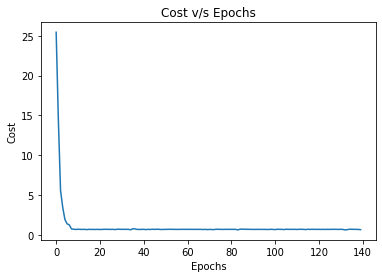

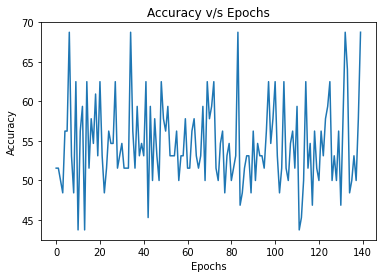

CPU times: user 1.16 s, sys: 18.5 ms, total: 1.18 s
Wall time: 1.16 s


In [ ]:
%%time
np.random.seed(10)
X = np.random.randn(15, 400)
y = np.random.randint(0, 2, size=(1, 400))

w, b = training(X, y, optimization_algo='mini_batch', optimization_method='Adam', regularization='L2', drop_nodes=0, batch_size=64, neural_layers=[8, 4, 4], initializer='He_random', epochs=20, num_iterations=10, non_linear_function='sigmoid', learning_rate=0.3, beta1=0.9, beta2=0.999, lmbda=2, gradient_checking=True, decay_rate=0.3)
# print(w)
# print(b)